# GRB image analysis (miniDC2)

updated on 2023-11-20

This notebook focuses on the image analysis with the image deconvolution code with the commit c54e4a89796980056ea4e5ffe9c2b4411b7deed1. Using the GRB simulation data created for miniDC2, an example of the image analysis will be presented.

If you want to know about the other analysis, e.g., the spectral analysis, you can see the notebooks in docs/tutorials/spectral_fits.

### Note that when the headline is inside parentheses it is not necessary to run the following cell, which is prepared for readers to understand the code clearly

In [2]:
from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy import BinnedData, Band_Eflux
from cosipy.image_deconvolution import DataLoader
from cosipy.image_deconvolution import ImageDeconvolution

from histpy import Histogram, HealpixAxis, Axis
from mhealpy import HealpixMap,HealpixBase

import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord, ICRS, Galactic, FK4, FK5
from astropy.time import Time
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from astromodels import Band
from threeML import Band, PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter

#Other standard libraries
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import healpy as hp
import os
import pprint

# 0. Data reduction

Before running the cells, please download the files needed for this notebook. You can get them from wasabi. 

Actually, the data reduction is not optimized and takes hours depending on your environments. So I skip this process.
Please download the following data files and then run the following cells.

From wasabi
- cosi-pipeline-public/ComptonSphere/mini-DC2/FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip (please unzip it)
- cosi-pipeline-public/ComptonSphere/mini-DC2/bkg_binned_data_full.hdf5
- cosi-pipeline-public/ComptonSphere/mini-DC2/grb_binned_data.hdf5
- cosi-pipeline-public/ComptonSphere/mini-DC2/grb_bkg_binned_data.hdf5

From docs/tutorials/image_deconvolution/GRB
- 20280301_first_2hrs.ori
- grb_dataIO_config.yml
- imagedeconvolution_parfile_GRB_miniDC2.yml

You can download the data and detector response from wasabi. You can skip this cell if you already have downloaded the files

In [ ]:
file_list = ['FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip', 'bkg_binned_data_full.hdf5', 'grb_binned_data.hdf5', 'grb_bkg_binned_data.hdf5']

for each in file_list:
    os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key ComptonSphere/mini-DC2/%s --endpoint-url=https://s3.us-west-1.wasabisys.com %s" %(each,each))

# 1. Read the response matrix

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [3]:
path_data = "path/to/data/"

In [4]:
response_path = path_data + "FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5"

response = FullDetectorResponse.open(response_path)

# 2. Read binned GRB files (source and background)

In [5]:
%%time

#  background over 2-hour observation
bkg_data = BinnedData(path_data + "grb_dataIO_config.yml")
bkg_data.load_binned_data_from_hdf5(path_data + 'bkg_binned_data_full.hdf5')

#  GRB + background around the event
grb_data = BinnedData(path_data + "grb_dataIO_config.yml")
grb_data.load_binned_data_from_hdf5(path_data + 'grb_bkg_binned_data.hdf5')

# only the GRB signal around the event (we don't use it in the analysis)
signal_data = BinnedData(path_data + "grb_dataIO_config.yml")
signal_data.load_binned_data_from_hdf5(path_data + 'grb_binned_data.hdf5')

CPU times: user 10.3 s, sys: 1.04 s, total: 11.3 s
Wall time: 11.3 s


## Check that the duration of bkg_data is 7200 sec = 2 hours

In [6]:
bkg_data.binned_data.axes['Time'].hi_lim - bkg_data.binned_data.axes['Time'].lo_lim

7200.0

## Check that the duration of grb_data is 2 sec

In [7]:
grb_data.binned_data.axes['Time'].hi_lim - grb_data.binned_data.axes['Time'].lo_lim

1.999995231628418

## Defne the scale factor for the background data

In [8]:
ratio_bkg_to_grbdata = (bkg_data.binned_data.axes['Time'].hi_lim - bkg_data.binned_data.axes['Time'].lo_lim) / (grb_data.binned_data.axes['Time'].hi_lim - grb_data.binned_data.axes['Time'].lo_lim)
ratio_bkg_to_grbdata

3600.0085830893113

## The start and stop times of the GRB binned data

In [9]:
grb_start_time = int(grb_data.binned_data.axes['Time'].lo_lim)
grb_stop_time = int(grb_data.binned_data.axes['Time'].hi_lim)

print("GRB start time:", grb_start_time)
print("GRB stop time:", grb_stop_time)

GRB start time: 1835481433
GRB stop time: 1835481435


## Modify the axis (this is just for this case!)

<span style="color:red">Here the time axis in the data and background files are modified as a single time bin. This is because the current code requires the same time intervals in both files.</span>


<span style="color:red">The background files is renormalized because the background is 2-hour data while the source data is 2-s duration.</span>


<span style="color:red">Such file modification may be confusing, so it will be modified in the future.</span>

In [10]:
%%time

grb_data.binned_data = Histogram.concatenate(Axis([grb_start_time, grb_stop_time], label = 'Time'), [grb_data.binned_data.project('Em', 'Phi', 'PsiChi')])
bkg_data.binned_data = Histogram.concatenate(Axis([grb_start_time, grb_stop_time], label = 'Time'), [bkg_data.binned_data.project('Em', 'Phi', 'PsiChi')/ratio_bkg_to_grbdata])

CPU times: user 19.7 s, sys: 1.75 s, total: 21.5 s
Wall time: 21.5 s


### (View the events in Compton Data Space)

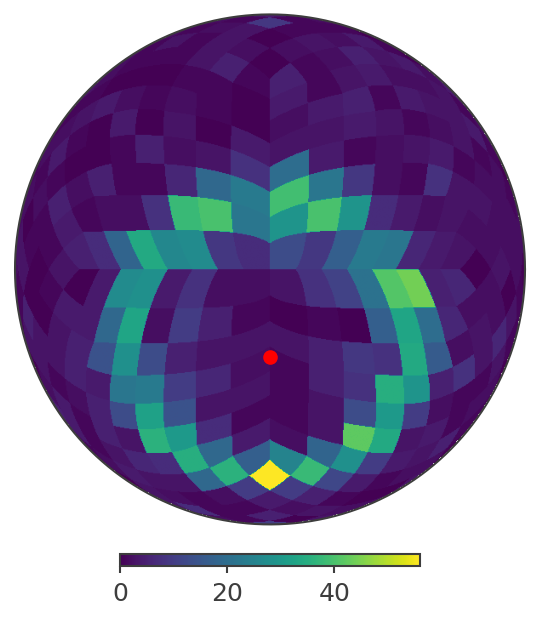

In [11]:
h = grb_data.binned_data.project('Em', 'Phi', 'PsiChi').slice[{'Em':2, 'Phi':3}].project('PsiChi')
m = HealpixMap(base = HealpixBase(npix = h.nbins), data = h.contents.todense())

_,ax = m.plot('orthview', ax_kw = {'rot':[0,90,0]})
#_,ax = m.plot('mollview')

ax.scatter(0, 70, transform=ax.get_transform('world'), color = 'red')

# 3. SC orientation

## Read the orientation file and extract the orientation information around the GRB interval

In [12]:
ori = SpacecraftFile.parse_from_file(path_data + "20280301_first_2hrs.ori")

#Set the GRB duration
Timemin = Time(grb_start_time,format = 'unix')
Timemax = Time(grb_stop_time,format = 'unix')
grbori = ori.source_interval(Timemin, Timemax)

### (calculate the dwell time map, not mandatory)

In [13]:
# Simulating a 2 second GRB at l = 51, b = -17 in Galacti coordinates.
coord = SkyCoord(l = 51*u.deg, b = -17*u.deg,
                 frame = 'galactic', attitude = Attitude.identity(frame = 'galactic')) 

In [14]:
# Initiate a SpacecraftPositionAttitude object with the coordinates of the source
#SCPosition = SpacecraftPositionAttitude.SourceSpacecraft("GRB", coord) 

# From the orientation, get the attitude and define the source movement in the spacecraft FOV
dts = grbori.get_time_delta()

src_movement = grbori.get_target_in_sc_frame("GRB", coord) 

Now converting to the Spacecraft frame...
Conversion completed!


In [15]:
dwell_time_map = grbori.get_dwell_map(response = response_path, dts = dts, src_path = src_movement)

Failed to transform from 'spacecraftframe' to 'icrs'. Rasterizing in 'spacecraftframe' frame. ERROR: Spacecraft coordinates need attitude to transform from ICRS


(<matplotlib.image.AxesImage at 0x2ce221a50>, <Mollview: >)

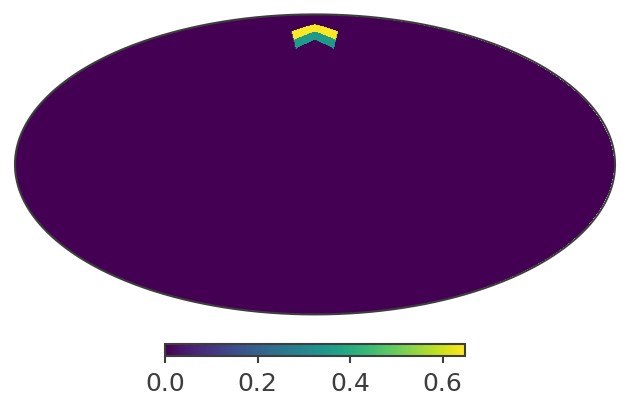

In [16]:
dwell_time_map.plot()

# 4. Imaging deconvolution

## Brief overview of the image deconvolution

Basically, we have to maximize the following likelihood function

$$
\log L = \sum_i X_i \log \epsilon_i - \sum_i \epsilon_i
$$

$X_i$: detected counts ( $i$ : index of the Compton Data Space)

$\epsilon_i = \sum_j R_{ij} \lambda_j + b_i$ : expected counts ( $j$ : index of the model space)

$\lambda_j$ : the model map

$b_i$ : the background at the index $i$

$R_{ij}$ : the response matrix

Since we have to optimize the flux in each pixel, and the number of parameters are large, we adopt an iterative approach to find a solution of the above equation. The simplest one is ML-EM (maximum likelihood expectation maximazation) algorithm.

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \delta \lambda_{j}^{k} \\
\delta \lambda_{j}^{k} = \frac{\lambda_{j}^{k}}{\sum_{i} R_{ij}} \sum_{i} \left(\frac{ X_{i} }{\epsilon_{i}} - 1 \right) R_{ij} 
$$

We refer to $\delta \lambda_{j}^{k}$ as the delta map.

As for now, the two improved algorithms are implemented.

- Accelerated ML-EM algorithm (Knoedlseder+99)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \delta \lambda_{j}^{k} \\
\alpha^{k} < \mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k})
$$

Paractically, in order not to accelerate the algorithm excessively, we set the maximu value of $\alpha$. Thus, $\alpha$ can be determined as:

$$
\alpha^{k} = \mathrm{min}(\mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k}), \alpha_{max})
$$

- Noise damping using gaussian smoothing (Knoedlseder+05, Siegert+20)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \left[ w_j \delta \lambda_{j}^{k} \right]_{\mathrm{gauss}} \\
w_j = \left(\sum_{i} R_{ij}\right)^\beta
$$

$\left[ ... \right]_{\mathrm{gauss}}$ means that the differential image is smoothed by a gaussian filter.

## 4-1. Prepare DataLoader containing all neccesary datasets

In [17]:
dataloader = DataLoader.load(grb_data.binned_data, 
                             bkg_data.binned_data, 
                             response, 
                             grbori,
                             is_miniDC2_format = True)

DataLoader is a data container for the image deconvolution. It also calculates several matrices for the analysis.

## 4-2. Load the response file

The response file will be loaded on the CPU memory. It requires a few GB. In the actuall analysis, the response will be much larger, ~TB. 

So loading it on the memory might be unrealistic. The optimized (lazy) loading would be a next work.

In [18]:
%%time

dataloader.load_full_detector_response_on_memory()

  0%|          | 0/768 [00:00<?, ?it/s]

CPU times: user 16.1 s, sys: 15 s, total: 31.1 s
Wall time: 31 s


(the following function is tentetive. It will be removed in the future.)

In [19]:
dataloader._modify_axes()

Note that this function is tentetive. It should be removed in the future!
Please run this function only once!
... checking the axis Time of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.


## 4-3. Calculate a dwell time map on each pixel/time bin

Here we calculate the dwell time map on each sky pixel and each time bin, and then combine them as a coordinate conversion matrix (ccm).

The ccm $C^{lb, \nu\lambda}_{t}$ is a three-dimentional matrix with the axes of 'lb', 'Time' and 'NuLambda'.

$C^{lb, \nu\lambda}_{t}$ is the dwell time map on the local coordinate pixel $\nu\lambda$ for the sky pixel $lb$ (in the galactic coordinate) during the time bin $t$.

Effectively, $C^{lb, \nu\lambda}_{t}$ acts as the coordinate conversion matrix of the sky map from the galactic coordinate to the local coordinate for each time bin.

In [20]:
%%time

dataloader.calc_coordsys_conv_matrix()

... checking the file registration ...
    --> pass
... checking the axis consistency ...
    --> pass
... (DataLoader) calculating a coordinate conversion matrix...


  0%|          | 0/768 [00:00<?, ?it/s]

... (DataLoader) calculating a projected image response ...
CPU times: user 8.85 s, sys: 611 ms, total: 9.46 s
Wall time: 9.45 s


### (you can save/load the ccm as follows)

If you save the coordsys conversion matrix, you can load it and do not have to calculate it again, which may save your time.

In [21]:
dataloader.save_coordsys_conv_matrix("coordsys_conv_matrix.hdf5")

In [22]:
%%time

dataloader.load_coordsys_conv_matrix_from_filepath("coordsys_conv_matrix.hdf5")

... checking the file registration ...
    --> pass
... checking the axis consistency ...
    --> pass
... (DataLoader) loading a coordinate conversion matrix...
... checking the axes of the coordinate conversion matrix ...
    --> pass (unit)
    --> pass (axis lb)
    --> pass (axis Time)
    --> pass (axis NuLambda)
... (DataLoader) calculating a projected image response ...
CPU times: user 144 ms, sys: 173 ms, total: 317 ms
Wall time: 323 ms


## 4-4. Initialize the instance of the image deconvolution class

First we prepare an instance of ImageDeconvolution class, and then, resister the dataset, parameters for the deconvolution. After that, you can start the calculation.

<span style="color:red"> please modify this parameter_filepath corresponding to your environment.</span>

In [23]:
parameter_filepath = path_data + "/imagedeconvolution_parfile_GRB_miniDC2.yml"

In [24]:
image_deconvolution = ImageDeconvolution()

# set dataloader to image_deconvolution
image_deconvolution.set_data(dataloader)

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

data for image deconvolution was set ->  <cosipy.image_deconvolution.data_loader.DataLoader object at 0x2ce28f580>
parameter file for image deconvolution was set ->  /Users/yoneda/Work/Exp/COSI/cosipy-2/miniDC2/example_notebook//imagedeconvolution_parfile_GRB_miniDC2.yml


### Initialize image_deconvolution

In this process, a model map is defined following the input parameters, and it is initialized. Also, it prepares ancillary data for the image deconvolution

I describe the parameters in the parameter file.

#### The description of parameters: model_property

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| coordinate | str | the coordinate system of the model map | As for now, it must be 'galactic' |
| nside | int | NSIDE of the model map | As for now, it must be the same as that of the response matrix |
| scheme | str | SCHEME of the model map | As for now, it must be 'ring' |
| energy_edges | list of float [keV] | The definition of the energy bins of the model map | As for now, it must be the same as that of the response matrix |

#### The description of parameters: model_initialization

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| algorithm | str | the method name to initialize the model map | As for now, only 'flat' can be used |
| parameter_flat:values | list of float [cm-2 s-1 sr-1] | the list of photon fluxes for each energy band | the length of the list should be the same as "the number of energy_edges - 1" |

#### The description of parameters: deconvolution

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
|algorithm | str | the name of the image deconvolution algorithm| As for now, only 'RL_memsave' is supported |
|||||
|parameter_RL_memsave:iteration | int | The maximum number of the iteration | |
|parameter_RL_memsave:acceleration | bool | whether the accelerated ML-EM algorithm (Knoedlseder+99) is used | |
|parameter_RL_memsave:alpha_max | float | the maximum value for the acceleration | |
|parameter_RL_memsave:save_results_each_iteration | bool | whether a updated model map, detal map, likelihood etc. are save at the end of each iteration | |
|parameter_RL_memsave:response_weighting | bool | whether a factor $w_j = (\sum_{i} R_{ij})^{\beta}$ for weighting the delta image is introduced (see Knoedlseder+05, Siegert+20) | |
|parameter_RL_memsave:response_weighting_index | float | $\beta$ in the above equation | |
|parameter_RL_memsave:smoothing | bool | whether a Gaussian filter is used (see Knoedlseder+05, Siegert+20)  | |
|parameter_RL_memsave:smoothing_FWHM | float, degree | the FWHM of the Gaussian in the filter | |
|parameter_RL_memsave:smoothing_max_sigma | float | a threshold for the Gaussian fileter calculation | should be larger than ~5 |
|parameter_RL_memsave:background_normalization_fitting | bool | whether the background normalization is optimized at each iteration | As for now, the same single background normalization factor is used in all of the time bins |
|parameter_RL_memsave:background_normalization_range | list of float | the range of the normalization factor | should be positive |

In [25]:
image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 100.0
- 200.0
- 500.0
- 1000.0
- 2000.0
- 5000.0
nside: 8
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 0.01
  - 0.01
  - 0.01
  - 0.01
  - 0.01

3. resistering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/768 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 10.0
  background_normalization_fitting: false
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 100
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 2.0
  smoothing_max_sigma: 10.0

#### Done ####



### (You can change the parameters as follows)

Note that when you modify the parameters, do not forget to run "initialize" again!

In [26]:
image_deconvolution.override_parameter("deconvolution:parameter_RL:iteration = 30")
image_deconvolution.override_parameter("deconvolution:parameter_RL:background_normalization_fitting = True")
image_deconvolution.override_parameter("deconvolution:parameter_RL:alpha_max = 5")
image_deconvolution.override_parameter("deconvolution:parameter_RL:smoothing_FWHM = 4.0")

image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 100.0
- 200.0
- 500.0
- 1000.0
- 2000.0
- 5000.0
nside: 8
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 0.01
  - 0.01
  - 0.01
  - 0.01
  - 0.01

3. resistering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/768 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 5
  background_normalization_fitting: true
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 30
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 4.0
  smoothing_max_sigma: 10.0

#### Done ####



## 4-5. Start the image deconvolution

In [27]:
%%time

all_results = image_deconvolution.run_deconvolution()

#### Deconvolution Starts ####


  0%|          | 0/30 [00:00<?, ?it/s]

  Iteration 1/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step



WARNING RuntimeWarning: invalid value encountered in divide



bkg_norm :  1.9156072920952
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
  Iteration 2/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
bkg_norm :  1.3794149487737983
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
  Iteration 3/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
bkg_norm :  1.479097442532033
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
  Iteration 4/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
bkg_norm :  1.130174952686566
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
  Iterat

In [28]:
pprint.pprint(all_results)

[{'alpha': <Quantity 4.52521502>,
  'background_normalization': 1.9156072920952,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2cc6fea40>,
  'iteration': 1,
  'loglikelihood': 6997.26072057744,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2cc6ff2e0>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2cc6fc7f0>},
 {'alpha': <Quantity 1.57622778>,
  'background_normalization': 1.3794149487737983,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2cc988dc0>,
  'iteration': 2,
  'loglikelihood': 24101.303106190535,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2cc9883d0>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2cc6feb60>},
 {'alpha': 5,
  'background_normalization': 1.479097442532033,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2cc6fe7a0>,
  'iteration': 3,
  'loglikelihood': 25029.

# 5. Analyze the results

Below examples to see/analyze the results are shown.

## Log-likelihood

Plotting the log-likelihood vs the number of iterations

Text(0, 0.5, 'loglikelihood')

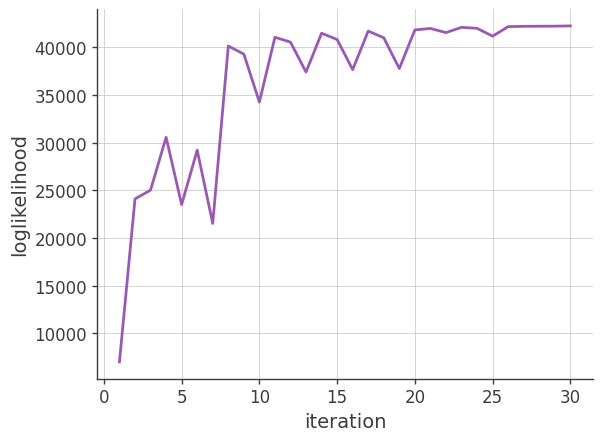

In [29]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")

## Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

Text(0, 0.5, 'alpha')

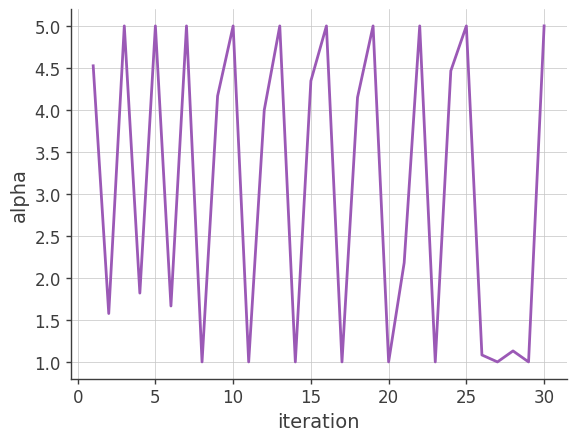

In [30]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")

## Background normalization

Plotting the background nomalization factor vs the number of iterations. If the backgroud model is accurate and the image is reconstructed perfectly, this factor should be close to 1. In this case, the background is slightly off from one, which may be because the background events are extracted from different time intervals of the GRB events.

Text(0, 0.5, 'background_normalization')

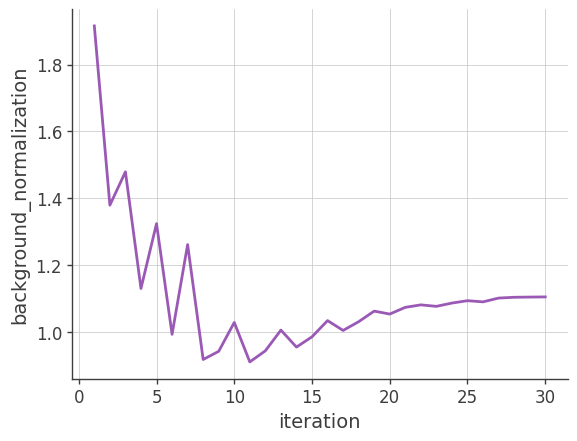

In [31]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['background_normalization'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")

## The reconstructed images

In [32]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

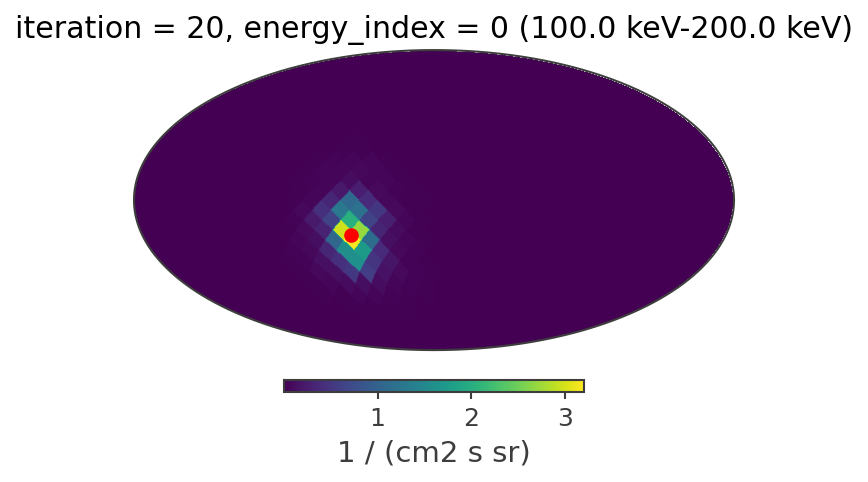

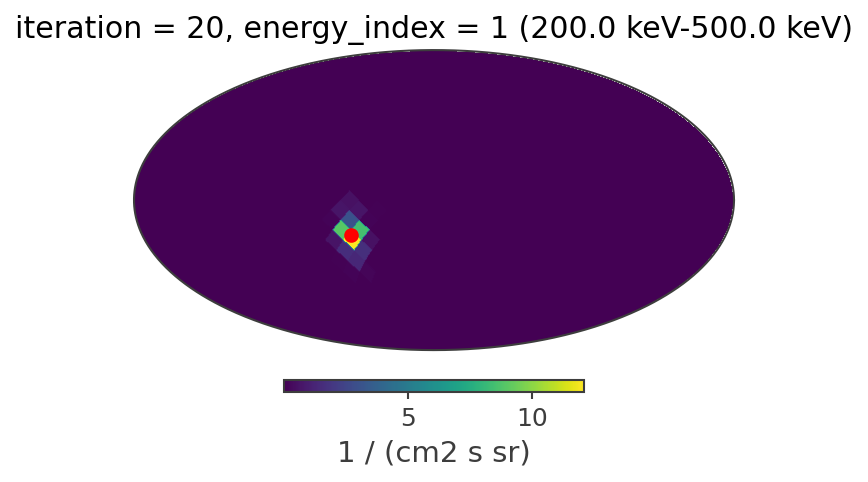

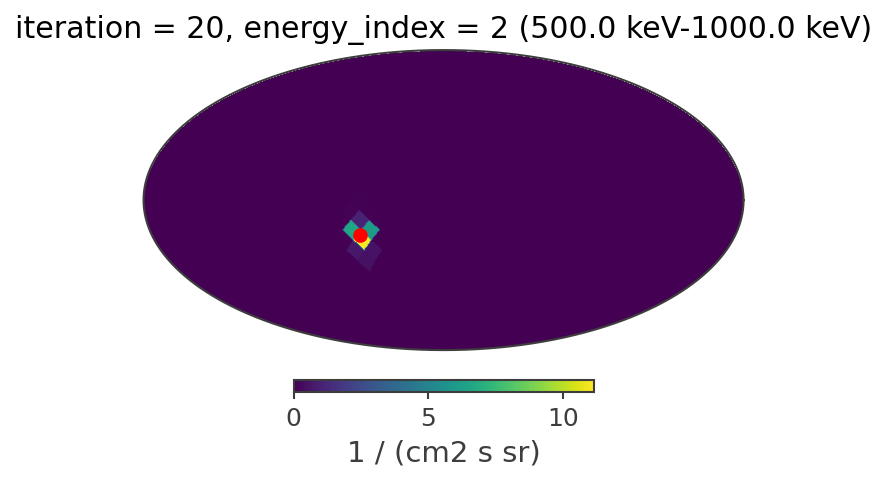

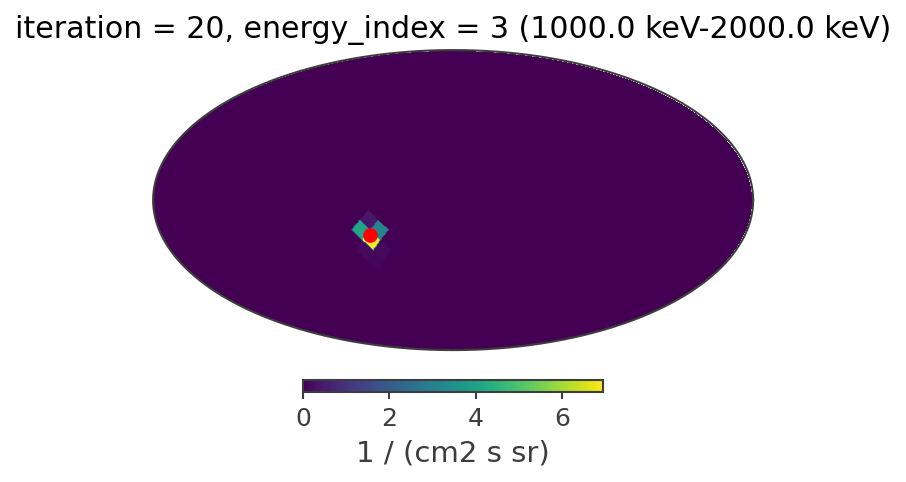

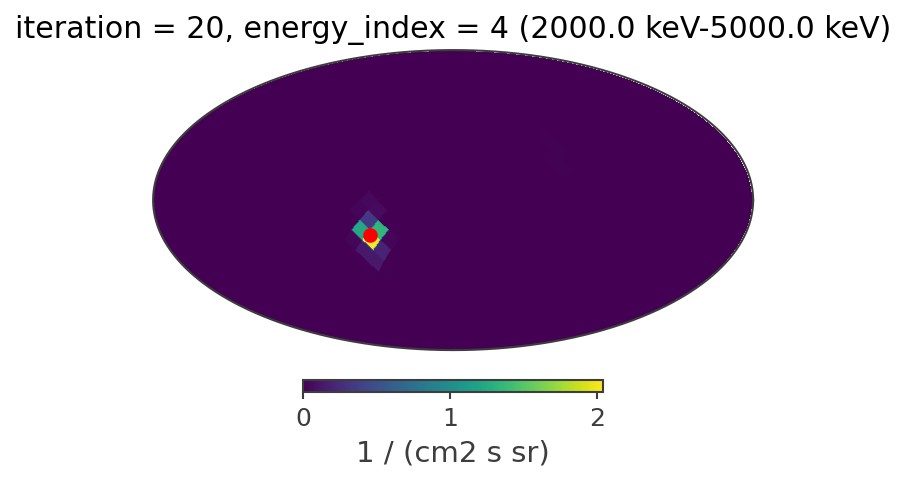

In [33]:
iteration = 19

plot_reconstructed_image(all_results[iteration], source_position = (51 * u.deg, -17 * u.deg))

You can plot the reconstructed images from all of the iterations. Note that the following cell produces lots of figures.

In [ ]:
for result in all_results:
    plot_reconstructed_image(result, source_position = (51 * u.deg, -17 * u.deg))

## Delta image
checking the difference between images before/after each iteration

In [35]:
def plot_delta_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['delta_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the difference between 19th and 20th reconstructed images.

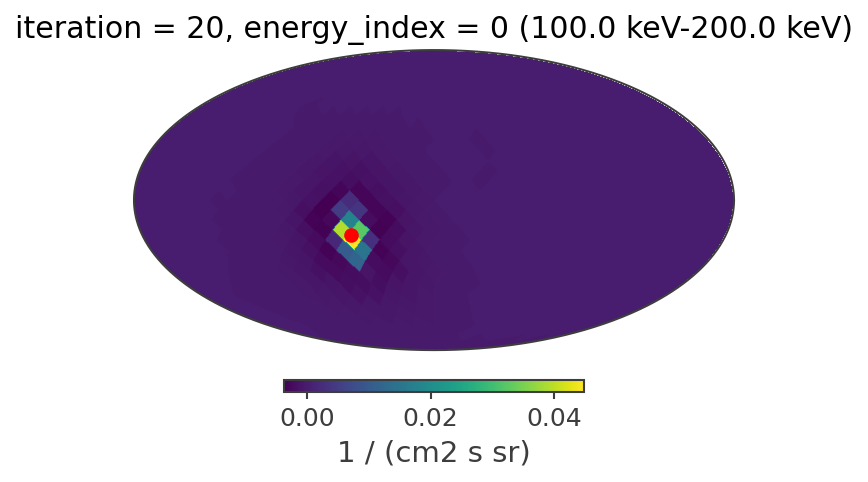

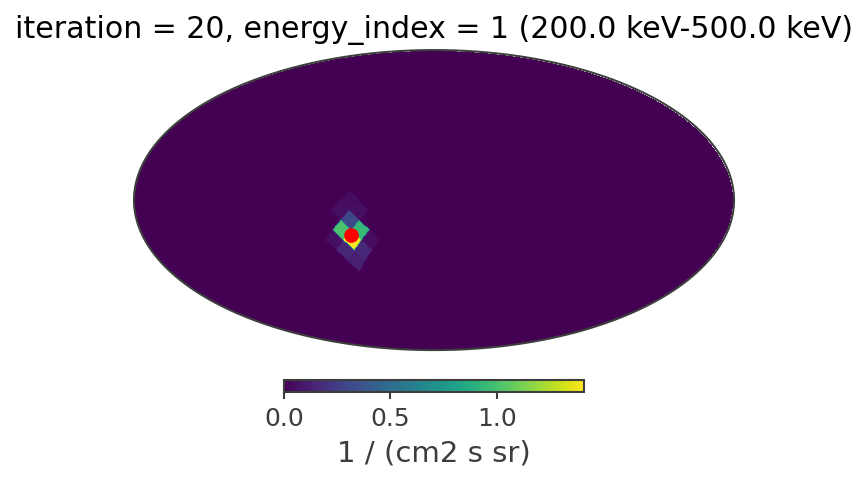

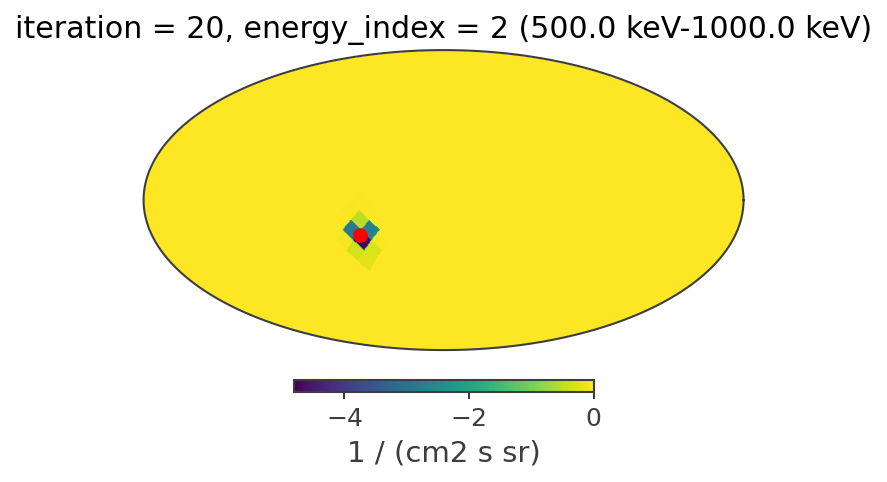

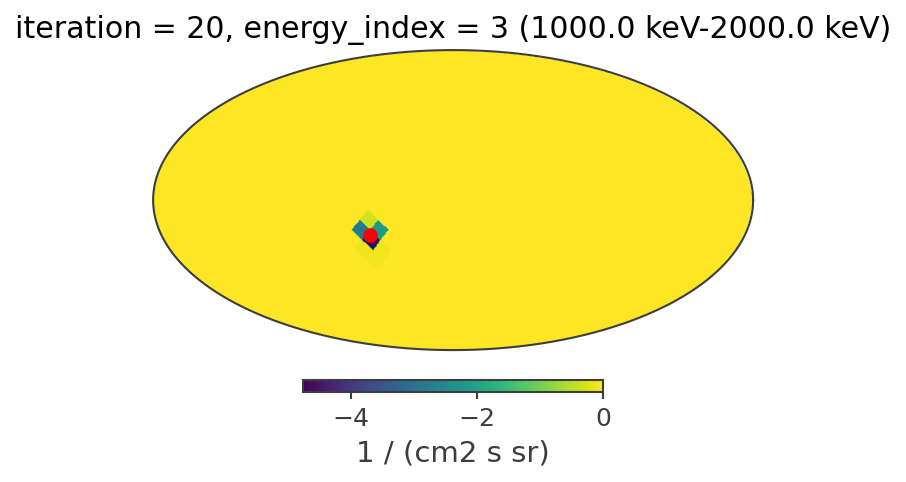

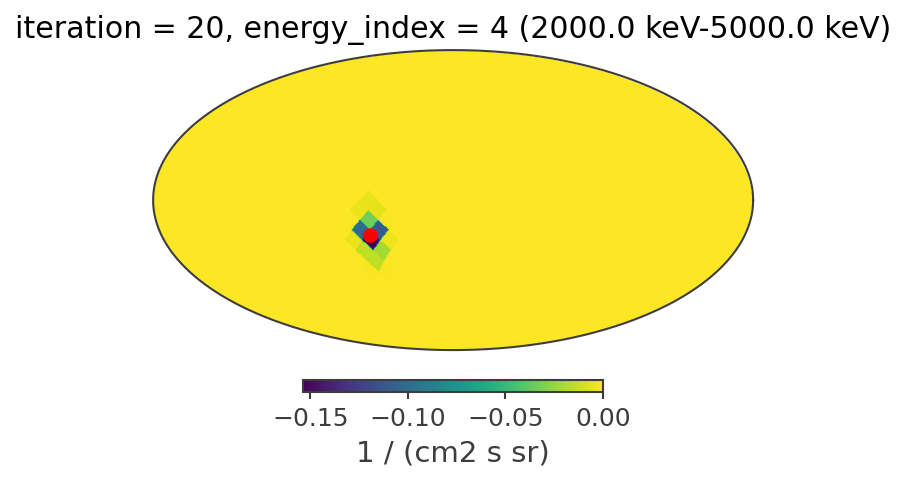

In [36]:
iteration = 19

plot_delta_image(all_results[iteration], source_position = (51 * u.deg, -17 * u.deg))

You can plot the reconstructed images from all of the iterations. Note that the following cell produces lots of figures.

In [ ]:
for result in all_results:
    plot_delta_image(result, source_position = (51 * u.deg, -17 * u.deg))

## Integrated flux over the sky

Define the actual GRB spectral model

In [38]:
alpha_inj = -1.
beta_inj = -3.
E0_inj = 1000. * u.keV 
K_inj = 5. / u.cm / u.cm / u.s / u.keV             
Emin_inj = 10. * u.keV
Emax_inj = 5000. * u.keV

spectrum_inj = Band_Eflux(alpha=alpha_inj,
                          beta=beta_inj,
                          E0=E0_inj.value,
                          K=K_inj.value,
                          a=Emin_inj.value,
                          b=Emax_inj.value)

spectrum_inj.E0.unit = E0_inj.unit
spectrum_inj.K.unit = K_inj.unit
spectrum_inj.a.unit = Emin_inj.unit
spectrum_inj.b.unit = Emax_inj.unit

Calculate the integrated photon flux in each energy band

In [39]:
integrated_flux_each_band_truth = []
integrated_flux_truth = 0.0 / u.cm**2 / u.s

for energy_index in range(all_results[0]['model_map'].axes["Ei"].nbins):
    emin, emax = all_results[0]['model_map'].axes["Ei"].bounds[energy_index]

    integrated_flux_each_band_truth.append(integrate.quad(spectrum_inj, emin.value, emax.value)[0] / u.cm**2 / u.s)
    
    print(emin, emax)
    print("    truth:", integrated_flux_each_band_truth[energy_index])
    
    integrated_flux_truth += integrated_flux_each_band_truth[-1]

100.0 keV 200.0 keV
    truth: 0.7418347986463156 1 / (cm2 s)
200.0 keV 500.0 keV
    truth: 0.8192020113325374 1 / (cm2 s)
500.0 keV 1000.0 keV
    truth: 0.420663133134687 1 / (cm2 s)
1000.0 keV 2000.0 keV
    truth: 0.21068821854253272 1 / (cm2 s)
2000.0 keV 5000.0 keV
    truth: 0.07024548561978913 1 / (cm2 s)


Plotting the integratd flux in each energy band vs the number of interations

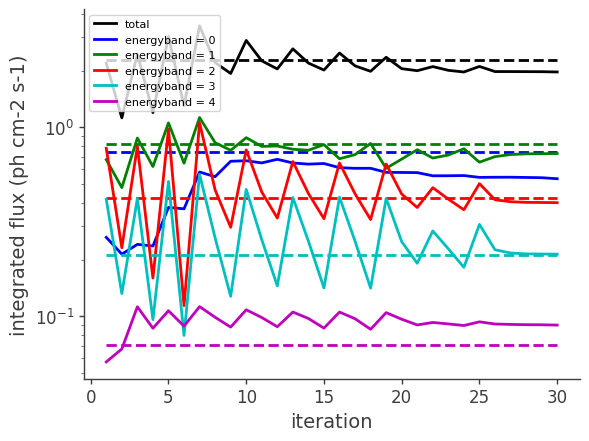

In [40]:
iteration = []
integrated_flux = []
integrated_flux_each_band = [[],[],[],[],[]]

for result in all_results:
    iteration.append(result['iteration'])
    image = result['model_map']
    pixelarea = 4 * np.pi / image.axes['lb'].npix * u.sr

    integrated_flux.append(np.sum(image) * pixelarea)

    for energy_band in range(image.axes['Ei'].nbins):
        integrated_flux_each_band[energy_band].append(np.sum(image[:,energy_band]) * pixelarea)
                
plt.plot(iteration, [_.value for _ in integrated_flux], label = 'total', color = 'black')
plt.plot(iteration, np.full(len(iteration), integrated_flux_truth), color = 'black', linestyle = "--")
plt.xlabel("iteration")
plt.ylabel("integrated flux (ph cm-2 s-1)")
plt.yscale("log")

colors = ['b', 'g', 'r', 'c', 'm']
for energy_band in range(5):
    plt.plot(iteration, [_.value for _ in integrated_flux_each_band[energy_band]], color = colors[energy_band], label = "energyband = {}".format(energy_band))
    plt.plot(iteration, np.full(len(iteration), integrated_flux_each_band_truth[energy_band]), color = colors[energy_band], linestyle = "--")

plt.legend()

## Spectrum

Plotting the gamma-ray spectrum at 20th interation. The photon flux at each energy band shown here is calculated as the accumulation of the flux values in all pixel at each energy band.

In [41]:
def get_differential_flux(model_map):
    pixelarea = 4 * np.pi / model_map.axes['lb'].npix * u.sr
        
    differential_flux = np.sum(model_map, axis = 0) * pixelarea / model_map.axes['Ei'].widths
    
    return differential_flux

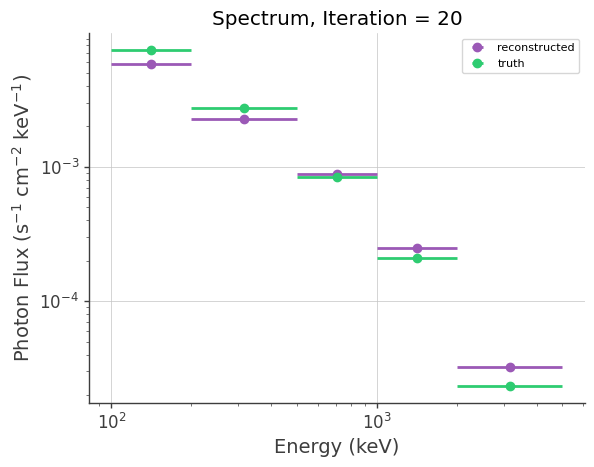

In [42]:
iteration = 19

result = all_results[iteration]

model_map = result['model_map']

differential_flux = get_differential_flux(model_map)

energy_band = model_map.axes['Ei'].centers

err_energy = model_map.axes['Ei'].bounds.T - model_map.axes['Ei'].centers
err_energy[0,:] *= -1

differential_flux_truth = [ integrated_flux / width for integrated_flux, width in zip(integrated_flux_each_band_truth, model_map.axes['Ei'].widths)]
        
plt.errorbar(energy_band, differential_flux, xerr=err_energy, fmt='o', label = 'reconstructed')
plt.errorbar(energy_band, [_.value for _ in differential_flux_truth], xerr=err_energy, fmt='o', label = 'truth')
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy (keV)")
plt.ylabel(r"Photon Flux (s$^{-1}$ cm$^{-2}$ keV$^{-1}$)")
plt.title(f"Spectrum, Iteration = {result['iteration']}")
plt.grid()
plt.legend()

## Find the location with the maximum flux
As an example, here it calculate the location of the maximum flux at the 20th iteration's map at the highest energy bin 

In [43]:
idx_iteration = 19
idx_energy = 4

argmax = np.argmax(all_results[idx_iteration]["model_map"].contents[:,idx_energy:idx_energy+1])
nside = all_results[idx_iteration]["model_map"].axes["lb"].nside
coordsys = all_results[idx_iteration]["model_map"].axes["lb"].coordsys

theta, phi = hp.pix2ang(nside, argmax)

l, b = phi * 180 / np.pi, 90 - theta * 180 / np.pi

c = SkyCoord(l, b, unit="deg", frame = coordsys)

print(f"The source position is around (l ,b) = ({c.galactic.l.deg} deg., {c.galactic.b.deg} deg.) in galactic")
print(f"The source position is around (ra, dec) = ({c.icrs.ra.deg} deg., {c.icrs.dec.deg} deg.) in icrs")

The source position is around (l ,b) = (50.62499999999999 deg., -19.47122063449069 deg.) in galactic
The source position is around (ra, dec) = (308.30194136772735 deg., 5.913074059175163 deg.) in icrs
